In [1]:
# ! git clone https://github.com/CodeArchitecture/FinRL.git

In [2]:
# import os
# os.chdir('/kaggle/working/FinRL')
# print(os.getcwd())

In [3]:
! pip install -r requirements.txt

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, get_baseline
import itertools
from finrl import config_tickers
from finrl.main import clean_and_make_directories
from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR, INDICATORS

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [15]:
clean_and_make_directories([TRAINED_MODEL_DIR, RESULTS_DIR, os.path.join(RESULTS_DIR,'a2c'),
                            os.path.join(RESULTS_DIR,'ddpg'),os.path.join(RESULTS_DIR,'ppo'),
                            os.path.join(RESULTS_DIR,'td3'),os.path.join(RESULTS_DIR,'sac')])

In [6]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2022-01-01'
TRADE_START_DATE = '2022-01-01'
TRADE_END_DATE = '2023-01-01'

TIMESTEPS = [100,100,100,100,100]
# TIMESTEPS = [50000,50000,50000,50000,50000]

In [7]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [9]:
df.shape

(103151, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.758534,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.832634,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.365306,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.579342,7117200,CAT,4


In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3523, 8)
Successfully added vix
Successfully added turbulence index


In [12]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [13]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)
# processed_full.to_csv('processed.csv')

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.758534,746015200.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,2.758534,2.758534,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.832634,6547900.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,43.832634,43.832634,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.365306,10955700.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,15.365306,15.365306,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941093,7010200.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,33.941093,33.941093,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.579342,7117200.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,31.579342,31.579342,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,11.948338,40980600.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,11.948338,11.948338,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,43.677200,13695900.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,43.677200,43.677200,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597500,9796600.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,20.597500,20.597500,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,69.251755,14088500.0,4.0,0.0,2.981391,2.652099,100.0,66.666667,100.0,69.251755,69.251755,39.189999,0.0


In [14]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

94917
7250


In [15]:
train.tail(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3272,2021-12-31,WBA,51.900002,52.419998,51.830002,49.202335,3406700.0,4.0,1.048742,49.688598,44.141082,60.665063,137.619069,39.560748,45.779740,45.587524,17.219999,12.130445
3272,2021-12-31,WMT,143.199997,145.039993,142.919998,141.869308,5982600.0,4.0,0.109482,143.596717,132.720990,52.959539,78.003502,11.277835,138.442673,140.434843,17.219999,12.130445


In [16]:
trade.head(2)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-03,AAPL,177.830002,182.880005,177.710007,180.683853,104487900.0,0.0,4.793321,182.498534,165.924217,64.844825,102.696135,50.480448,169.669382,158.567709,16.6,40.620617
0,2022-01-03,AMGN,223.630005,226.970001,222.029999,217.828110,2742800.0,0.0,4.656416,222.959185,198.827307,60.592127,90.811852,30.885704,205.461875,202.313809,16.6,40.620617


In [17]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [18]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [19]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [20]:
env_train, _ = StockTradingEnv(df = train, **env_kwargs).get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [21]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [22]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

trained_a2c = agent.train_model(model=model_a2c, 
                             total_timesteps=TIMESTEPS[0]) if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


### Agent 2: DDPG

In [23]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

trained_ddpg = agent.train_model(model=model_ddpg, 
                             total_timesteps=TIMESTEPS[1]) if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [24]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             total_timesteps=TIMESTEPS[2]) if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
------------------------------------
| time/              |             |
|    fps             | 40          |
|    iterations      | 1           |
|    time_elapsed    | 50          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.05787843 |
------------------------------------


### Agent 4: TD3

In [25]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

trained_td3 = agent.train_model(model=model_td3, 
                             total_timesteps=TIMESTEPS[3]) if if_using_td3 else None

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


d:\Anaconda\envs\fin\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 2.23GB
  warnings.warn(


### Agent 5: SAC

In [26]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

trained_sac = agent.train_model(model=model_sac, 
                             total_timesteps=TIMESTEPS[4]) if if_using_sac else None

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [27]:
insample_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)].drop_duplicates(subset=['date'])

count    3273.000000
mean       19.157809
std         8.189592
min         9.140000
25%        13.620000
50%        16.799999
75%        22.100000
max        82.690002
Name: vix, dtype: float64


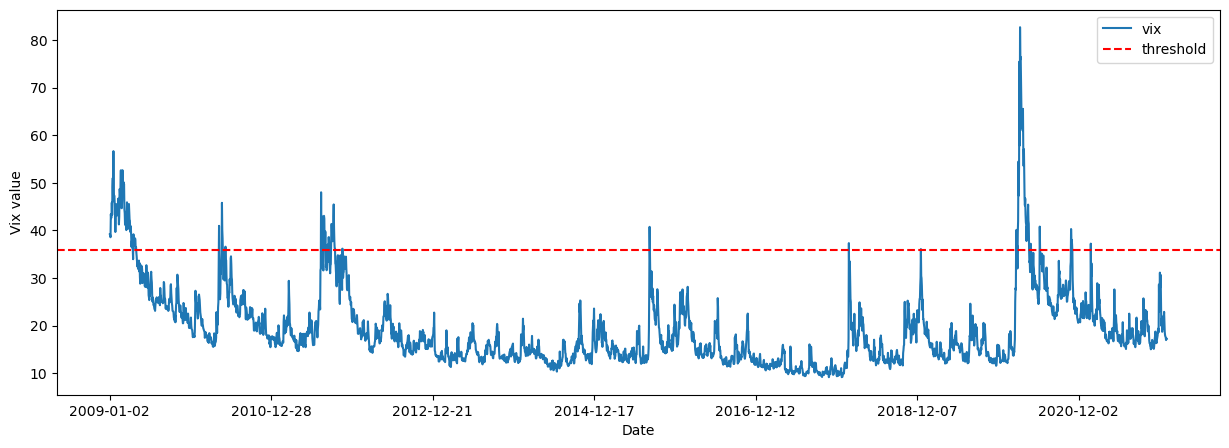

In [28]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/train_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/train_vix_describe.csv')

count    3273.000000
mean       33.876506
std        42.622762
min         0.000000
25%        14.736808
50%        23.666376
75%        37.990363
max       652.506418
Name: turbulence, dtype: float64


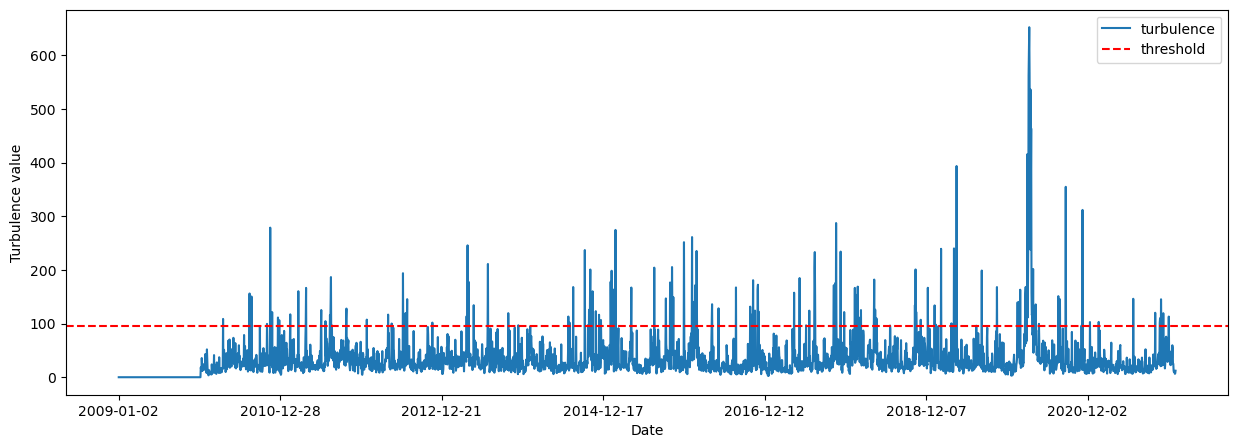

In [29]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/train_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/train_turbulence_describe.csv')

In [30]:
insample_risk_indicator = processed_full[(processed_full.date<TRADE_END_DATE) & (processed_full.date>=TRADE_START_DATE)].drop_duplicates(subset=['date'])

count    250.000000
mean      25.639720
std        4.216336
min       16.600000
25%       22.230000
50%       25.505000
75%       28.930001
max       36.450001
Name: vix, dtype: float64


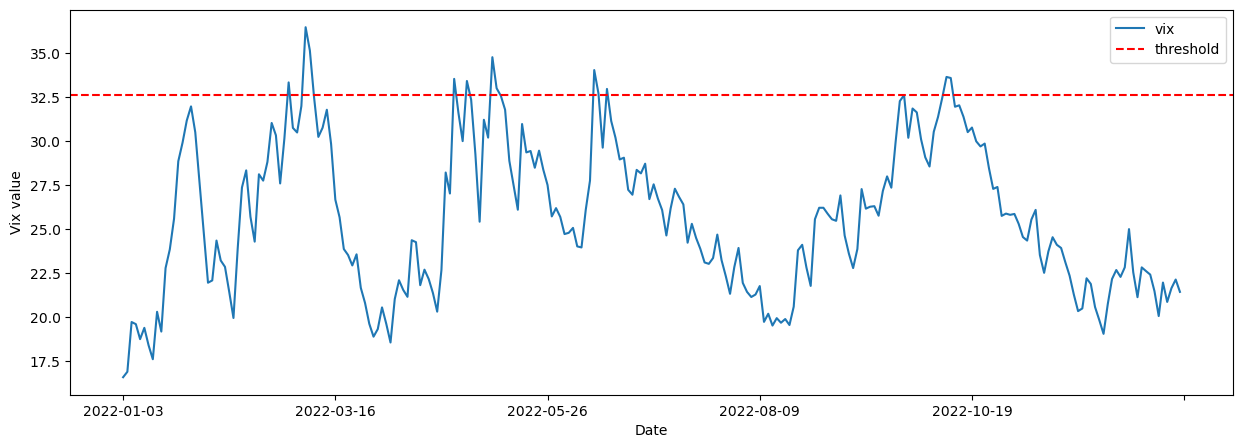

In [31]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
fig = insample_risk_indicator.set_index('date').vix.plot()
fig.axhline(y=insample_risk_indicator.vix.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Vix value')
fig.legend()
fig.get_figure().savefig('results/trade_vix.png')

print(insample_risk_indicator.vix.describe())
insample_risk_indicator.vix.describe().to_csv('results/trade_vix_describe.csv')

count    250.000000
mean      43.303491
std       36.993286
min        8.116759
25%       19.330137
50%       32.712719
75%       53.647363
max      248.259534
Name: turbulence, dtype: float64


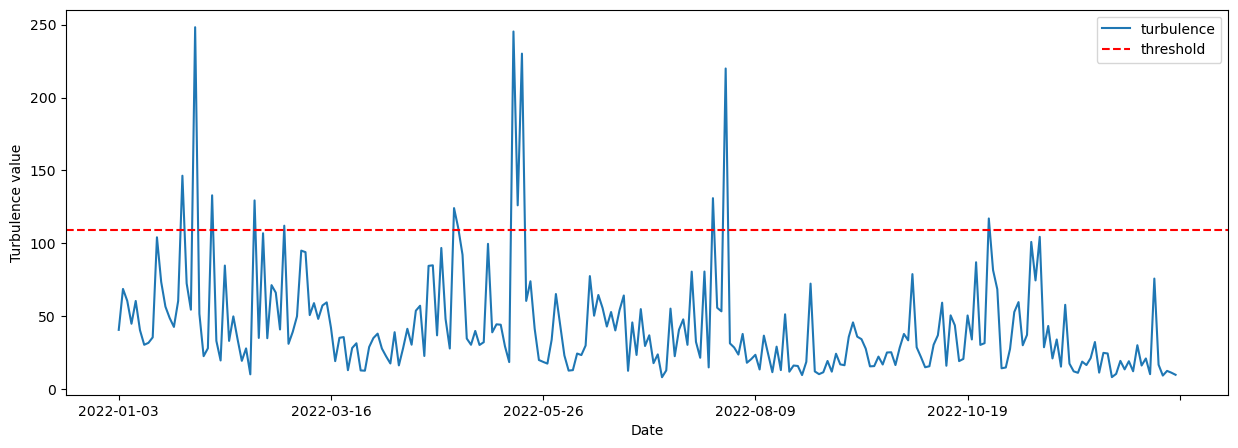

In [32]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
insample_risk_indicator.turbulence.describe()
fig = insample_risk_indicator.set_index('date').turbulence.plot()
fig.axhline(y=insample_risk_indicator.turbulence.quantile(0.95), color='r', linestyle='--',label='threshold')
fig.set_xlabel('Date')
fig.set_ylabel('Turbulence value')
fig.legend()
fig.get_figure().savefig('results/trade_turbulence')

print(insample_risk_indicator.turbulence.describe())
insample_risk_indicator.turbulence.describe().to_csv('results/trade_turbulence_describe.csv')

In [33]:
model_list = {'a2c':trained_a2c,'ddpg':trained_ddpg,'ppo':trained_ppo,'sac':trained_sac,'td3':trained_td3}
model_name_list = ['a2c','ddpg','ppo','sac','td3']
for i, model_name in enumerate(model_name_list):
    for j, vix_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.vix.quantile(vix_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_vix{}'.format(model_name,int(vix_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_vix{}'.format(model_name,int(vix_quantile*100)))
    for j, turbulence_quantile in enumerate([0.8,0.85,0.9,0.95]):
        e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.turbulence.quantile(turbulence_quantile),risk_indicator_col='vix', **env_kwargs)
        trained_model = model_list[model_name]
        df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment = e_trade_gym)
        df_account_value.set_index(df_account_value.columns[0]).to_csv('results/{}/df_account_value_turbulence{}'.format(model_name,int(turbulence_quantile*100)))
        df_actions.to_csv('results/{}/df_actions_turbulence{}'.format(model_name,int(turbulence_quantile*100)))

KeyboardInterrupt: 

In [ ]:
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(ticker="^DJI", start = TRADE_START_DATE, end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = pd.read_csv('results/a2c/df_account_value_turbulence80',index_col=0)['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_dji.csv")

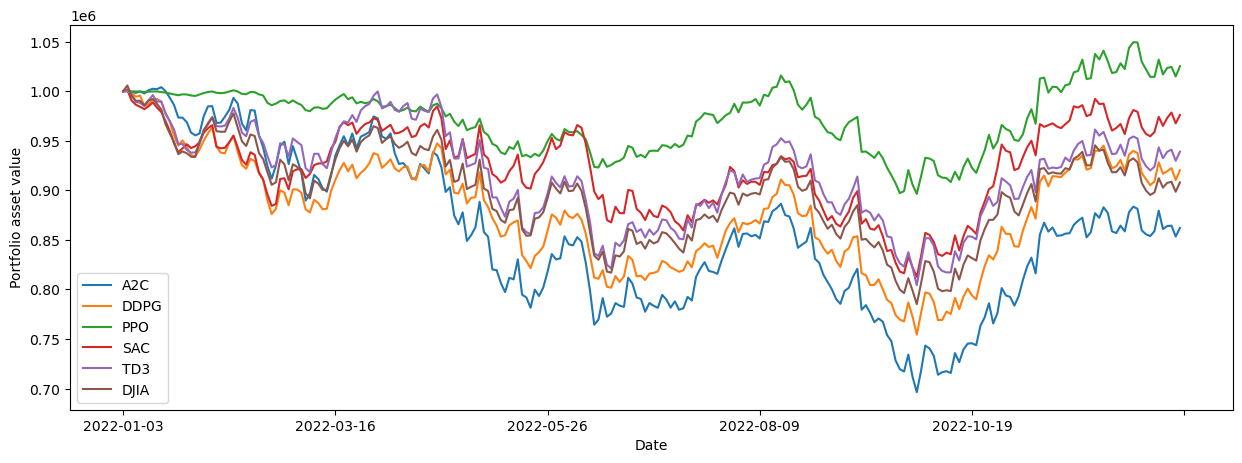

In [14]:
%matplotlib inline
df1 = pd.read_csv('results/a2c/df_account_value_turbulence90',index_col=0)
df2 = pd.read_csv('results/ddpg/df_account_value_turbulence90',index_col=0)
df3 = pd.read_csv('results/ppo/df_account_value_turbulence90',index_col=0)
df4 = pd.read_csv('results/sac/df_account_value_turbulence90',index_col=0)
df5 = pd.read_csv('results/td3/df_account_value_turbulence90',index_col=0)
df6 = pd.read_csv('results/df_dji.csv',index_col=0)

plt.rcParams["figure.figsize"] = (15,5)
df = pd.concat([df1,df2,df3,df4,df5,df6],axis=1)
df.columns=['A2C','DDPG','PPO','SAC','TD3','DJIA']
fig = df.plot()
fig.set_xlabel('Date')
fig.set_ylabel('Portfolio asset value')
plt.legend()
fig.get_figure().savefig('results/backtest.png')

In [ ]:
import shutil
folder_name = 'results'
zip_file_name = 'results'
shutil.make_archive(zip_file_name, 'zip', folder_name)

In [ ]:
# pd.DataFrame(backtest_stats(account_value=df_account_value_a2c)).to_csv('results/a2c_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ddpg)).to_csv('results/ddpg_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_td3)).to_csv('results/td3_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_ppo)).to_csv('results/ppo_perf.csv')
# pd.DataFrame(backtest_stats(account_value=df_account_value_sac)).to_csv('results/sac_perf.csv')

Annual return         -0.016552
Cumulative returns    -0.023108
Annual volatility      0.129391
Sharpe ratio          -0.064714
Calmar ratio          -0.112787
Stability              0.260002
Max drawdown          -0.146752
Omega ratio            0.987478
Sortino ratio         -0.088894
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.900032
Daily value at risk   -0.016335
dtype: float64


d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
